# Classifying the Risk of Default Payments of Purchases for an Online Trader

# Data Exploration and Model Selection

Name: Terry Lay

Student Number: N01601584

In [131]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

## Importing the Training Data

In [2]:
risk_train = pd.read_csv('data/risk-train.txt', sep='\t')
risk_train = risk_train.drop(['ORDER_ID'], axis=1)
risk_train.head()

,CLASS,B_EMAIL,B_TELEFON,B_BIRTHDATE,FLAG_LRIDENTISCH,FLAG_NEWSLETTER,Z_METHODE,Z_CARD_ART,Z_CARD_VALID,Z_LAST_NAME,...,FAIL_RPLZ,FAIL_RORT,FAIL_RPLZORTMATCH,SESSION_TIME,NEUKUNDE,AMOUNT_ORDER_PRE,VALUE_ORDER_PRE,DATE_LORDER,MAHN_AKT,MAHN_HOECHST
0,no,yes,no,1/17/1973,yes,yes,check,?,5.2006,?,...,no,no,no,8,yes,0,0.00,?,?,?
1,no,yes,yes,12/8/1970,no,no,credit_card,Visa,12.2007,yes,...,yes,no,no,13,yes,0,0.00,?,?,?
2,no,yes,no,4/3/1972,yes,no,check,?,12.2007,?,...,no,no,no,3,yes,0,0.00,?,?,?
3,no,no,yes,8/1/1966,yes,no,check,?,1.2007,?,...,no,no,no,11,no,4,75.72,5/12/2002,0,0
4,no,yes,yes,12/21/1969,yes,no,credit_card,Eurocard,12.2006,yes,...,no,no,no,16,yes,0,0.00,?,?,?


## Data Preprocessing

In [3]:
def check_missing(dataset):
# Function to check the number of '?' in the dataset.
    missing = dataset.isin(['?']).sum(axis=0)
    return missing[missing!=0]

In [4]:
risk_train.shape

(30000, 43)

### Missing Values

First we will handle the missing values in the dataset.

In [5]:
# Counting the number of missing values
check_missing(risk_train)

B_BIRTHDATE      2942
Z_CARD_ART      18654
Z_LAST_NAME     14808
TIME_ORDER         20
ANUMMER_02      22147
ANUMMER_03      26802
ANUMMER_04      28668
ANUMMER_05      29459
ANUMMER_06      29794
ANUMMER_07      29905
ANUMMER_08      29966
ANUMMER_09      29993
ANUMMER_10      30000
DATE_LORDER     15856
MAHN_AKT        15856
MAHN_HOECHST    15856
dtype: int64

In [6]:
risk_train['Z_METHODE'].value_counts()

check          14808
credit_card     9796
debit_note      3846
debit_card      1550
Name: Z_METHODE, dtype: int64

If a check is given then there is no data for the last name of the card holder. The number of missing values in Z_CARD_ART also corresponds to the number of payment methods that were checks or debit notes.

In [7]:
risk_train['Z_CARD_ART'].value_counts()

?             18654
Eurocard       5096
Visa           3927
debit_card     1550
Amex            773
Name: Z_CARD_ART, dtype: int64

In [8]:
risk_train.loc[risk_train.Z_METHODE == 'credit_card', 
               'Z_METHODE'] = risk_train.Z_CARD_ART
risk_train = risk_train.drop(['Z_CARD_ART','Z_LAST_NAME'], axis=1)

In [9]:
risk_train['Z_METHODE'].value_counts()

check         14808
Eurocard       5096
Visa           3927
debit_note     3846
debit_card     1550
Amex            773
Name: Z_METHODE, dtype: int64

Next, we will drop the ANUMMER columns indicating the item number, as the item ID is unlikely to influence the target variable.

In [10]:
risk_train = risk_train.drop(['ANUMMER_01', 
                 'ANUMMER_02',
                 'ANUMMER_03', 
                 'ANUMMER_04', 
                 'ANUMMER_05', 
                 'ANUMMER_06', 
                 'ANUMMER_07', 
                 'ANUMMER_08', 
                 'ANUMMER_09', 
                 'ANUMMER_10'], axis=1)

Let's see if whether or not a birthdate was submitted with the order has an effect on the class.

In [11]:
risk_train['BIRTHDATE_SUBMITTED'] = risk_train['B_BIRTHDATE'].apply(lambda x: 1 if not (x=='?') else 0)

In [12]:
crosstab = pd.crosstab(risk_train.BIRTHDATE_SUBMITTED, risk_train.CLASS, margins=True)
crosstab

CLASS,no,yes,All
BIRTHDATE_SUBMITTED,,,
0,2765,177,2942
1,25489,1569,27058
All,28254,1746,30000


<AxesSubplot:xlabel='BIRTHDATE_SUBMITTED'>

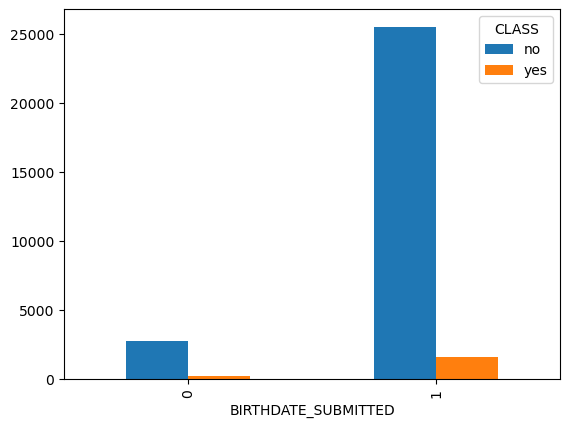

In [13]:
risk_train.groupby(['BIRTHDATE_SUBMITTED','CLASS']).size().unstack().plot(kind='bar')

We will drop the birthdate columns because it appears that the proportion of people who are high risk is not associated with whether they submitted their birthdate. 

In [14]:
risk_train = risk_train.drop(['BIRTHDATE_SUBMITTED', 'B_BIRTHDATE'], axis=1)

There may be a higher risk associated for those who are new customers. Let's see whether or not this is the case.

<AxesSubplot:xlabel='NEUKUNDE'>

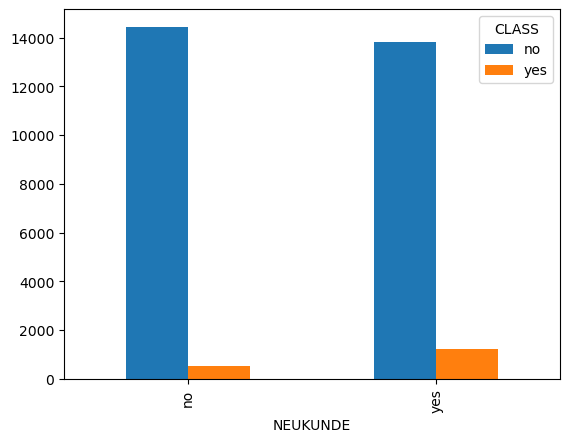

In [15]:
risk_train.groupby(['NEUKUNDE','CLASS']).size().unstack().plot(kind='bar')

It appears that new customers have a higher proportion of high risk to low risk purchases. We will drop columns related to returning customers since we also have many missing values for them.

In [16]:
risk_train = risk_train.drop(['AMOUNT_ORDER_PRE',
                              'VALUE_ORDER_PRE',
                              'DATE_LORDER',
                              'MAHN_AKT',
                              'MAHN_HOECHST'], axis=1)

The last column with missing values is TIME_ORDER. We will drop this column as well as we do not suspect that the time of order has an association with the risk of default payment.

In [17]:
risk_train = risk_train.drop(['TIME_ORDER'], axis=1)

In [18]:
check_missing(risk_train)

Series([], dtype: int64)

We were able to handle all missing values in the dataset.

### Data Exploration

The expiration date of the card (Z_CARD_VALID) is unlikely to have an association with the class variable. Let's visualize this to confirm whether or not this is true.

In [19]:
risk_train['Z_CARD_VALID_YEAR'] = risk_train['Z_CARD_VALID'].astype(str).str[-4:]

<AxesSubplot:xlabel='Z_CARD_VALID_YEAR'>

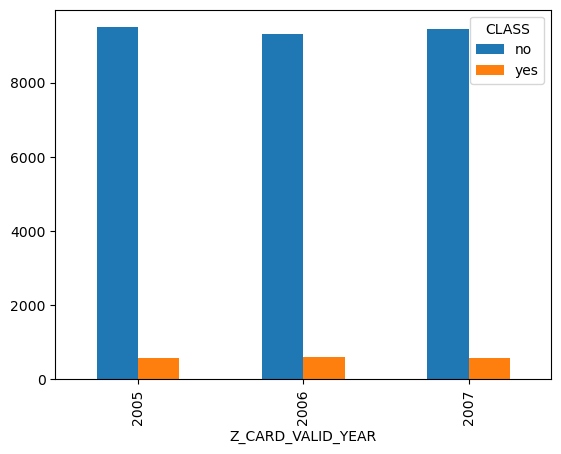

In [20]:
risk_train.groupby(['Z_CARD_VALID_YEAR','CLASS']).size().unstack().plot(kind='bar')

In [21]:
risk_train['Z_CARD_VALID_MONTH'] = risk_train['Z_CARD_VALID'].astype(int).astype(str)

<AxesSubplot:xlabel='Z_CARD_VALID_MONTH'>

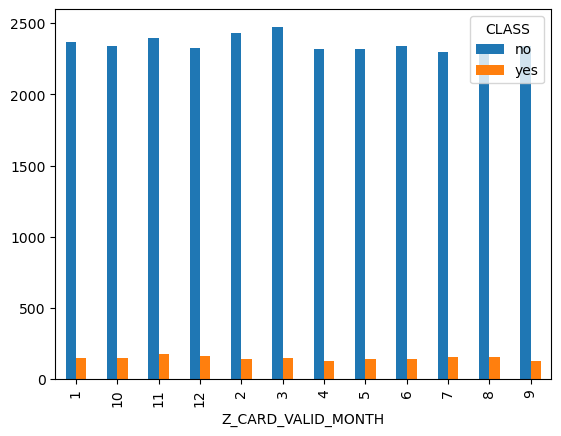

In [22]:
risk_train.groupby(['Z_CARD_VALID_MONTH','CLASS']).size().unstack().plot(kind='bar')

It looks like the class distribution is the same between the years and months so we will drop this column.

In [23]:
risk_train = risk_train.drop(['Z_CARD_VALID', 'Z_CARD_VALID_YEAR', 'Z_CARD_VALID_MONTH'], axis=1)

### Scaling the Data

We will scale VALUE_ORDER and SESSION_TIME to ensure they do not dominate the model.

In [163]:
scaler = MinMaxScaler()
risk_train[['VALUE_ORDER', 'SESSION_TIME']] = scaler.fit_transform(
    risk_train[['VALUE_ORDER', 'SESSION_TIME']])

### Class Distribution

There is a large inbalance between our majority and minority class as seen below:

<AxesSubplot:ylabel='CLASS'>

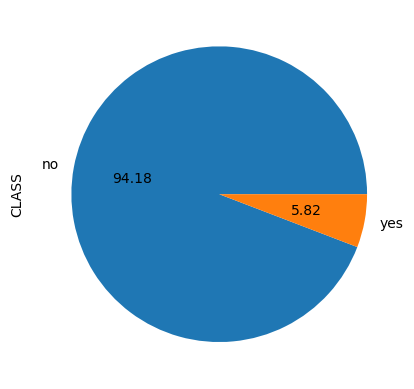

In [133]:
risk_train.CLASS.value_counts().plot.pie(autopct="%.2f")

We will need to consider weights when we perform our model training.

## Model Selection

We will explore various models to fit the data. We need to consider the inbalance in our class distribution. For simplicity, we will start by using balanced class weights but we may need to specify our own weights to tune our selected model since we have different misclassification costs for low and high risk orders.

In [164]:
def check_cost(cm):
    # Gets the confusion matrix and calculates the misclassification cost
    cost = cm[0][1]*5 + cm[1][0]*50 # False negative is more expensive
    return cost

#### Random Forest Model

Let's train a random forest model and see the feature importances.

In [135]:
risk_train_dummies = pd.get_dummies(risk_train, drop_first=True)
risk_train_dummies.columns

Index(['VALUE_ORDER', 'AMOUNT_ORDER', 'SESSION_TIME', 'CLASS_yes',
       'B_EMAIL_yes', 'B_TELEFON_yes', 'FLAG_LRIDENTISCH_yes',
       'FLAG_NEWSLETTER_yes', 'Z_METHODE_Eurocard', 'Z_METHODE_Visa',
       'Z_METHODE_check', 'Z_METHODE_debit_card', 'Z_METHODE_debit_note',
       'WEEKDAY_ORDER_Monday', 'WEEKDAY_ORDER_Saturday',
       'WEEKDAY_ORDER_Sunday', 'WEEKDAY_ORDER_Thursday',
       'WEEKDAY_ORDER_Tuesday', 'WEEKDAY_ORDER_Wednesday', 'CHK_LADR_yes',
       'CHK_RADR_yes', 'CHK_KTO_yes', 'CHK_CARD_yes', 'CHK_COOKIE_yes',
       'CHK_IP_yes', 'FAIL_LPLZ_yes', 'FAIL_LORT_yes', 'FAIL_LPLZORTMATCH_yes',
       'FAIL_RPLZ_yes', 'FAIL_RORT_yes', 'FAIL_RPLZORTMATCH_yes',
       'NEUKUNDE_yes'],
      dtype='object')

In [136]:
X = risk_train_dummies.drop('CLASS_yes', axis=1)
y = risk_train_dummies['CLASS_yes']
# Split the data 80%-20% into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y, 
                                                    test_size=0.2, 
                                                    random_state=0)

In [179]:
rf_model = RandomForestClassifier(n_estimators=150, 
                                  class_weight = 'balanced', 
                                  min_samples_split = 10, 
                                  random_state=0)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_split=10,
                       n_estimators=150, random_state=0)

In [180]:
y_pred_rf = rf_model.predict(X_test)

accuracy_score(y_test, y_pred_rf)

0.9078333333333334

In [181]:
# Check important features
feature_importances_df = pd.DataFrame({"feature": list(X.columns), "importance": rf_model.feature_importances_})
feature_importances_df.sort_values("importance", ascending=False, inplace=True)

feature_importances_df

,feature,importance
0,VALUE_ORDER,0.290539
2,SESSION_TIME,0.211717
30,NEUKUNDE_yes,0.064356
1,AMOUNT_ORDER,0.047989
3,B_EMAIL_yes,0.047231
4,B_TELEFON_yes,0.027541
18,CHK_LADR_yes,0.025930
5,FLAG_LRIDENTISCH_yes,0.023415
13,WEEKDAY_ORDER_Saturday,0.020637
14,WEEKDAY_ORDER_Sunday,0.020623


In [182]:
print(classification_report(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf)
print(cm)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5651
           1       0.17      0.15      0.16       349

    accuracy                           0.91      6000
   macro avg       0.56      0.55      0.55      6000
weighted avg       0.90      0.91      0.90      6000

[[5396  255]
 [ 298   51]]


In [183]:
check_cost(cm)

16175

#### XGBoost Model

In [170]:
model_xgb = XGBClassifier(random_state=0, scale_pos_weight = 10, )
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [171]:
y_pred_xgb = model_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred_xgb)
print(cm)

[[5048  603]
 [ 236  113]]


In [172]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      5651
           1       0.16      0.32      0.21       349

    accuracy                           0.86      6000
   macro avg       0.56      0.61      0.57      6000
weighted avg       0.91      0.86      0.88      6000



In [173]:
check_cost(cm)

14815

#### Logistic Regression Model

In [145]:
log_model = LogisticRegression(class_weight='balanced', random_state=0, n_jobs=-1)
log_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=0)

In [146]:
y_pred_lr = log_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_lr)
print(cm)

[[3675 1976]
 [ 101  248]]


In [147]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.97      0.65      0.78      5651
           1       0.11      0.71      0.19       349

    accuracy                           0.65      6000
   macro avg       0.54      0.68      0.49      6000
weighted avg       0.92      0.65      0.75      6000



In [148]:
check_cost(cm)

14930

The accuracy for the logistic regression model is lower, but since the class is inbalanced the tree models tend to classify most predictions as the majority (low risk). The accuracy score is misleading because we have such a low f1 score on the high risk group.

#### SVC Model

In [149]:
svc_model = SVC(class_weight='balanced', random_state=0)

In [150]:
svc_model.fit(X_train, y_train)

SVC(class_weight='balanced', random_state=0)

In [151]:
y_pred_svc = svc_model.predict(X_test)

In [152]:
print(classification_report(y_test, y_pred_svc))

cm = confusion_matrix(y_test, y_pred_svc)
print(cm)

              precision    recall  f1-score   support

           0       0.97      0.65      0.78      5651
           1       0.11      0.69      0.19       349

    accuracy                           0.65      6000
   macro avg       0.54      0.67      0.48      6000
weighted avg       0.92      0.65      0.74      6000

[[3655 1996]
 [ 107  242]]


In [153]:
check_cost(cm)

15330

Introducing bias to ensure more instances are classified as high risk sacrificed our accuracy scores but seemed to improve F1-scores and reduced cost. Although it had the highest accuracy, the random forest model is sensitive to class inbalance so we will choose to work with a logistic regression or SVC model.

## Tuning Class Weights

Let's try different hyperparameter values and compare SVC with Logistic Regression

In [154]:
log_model1 = LogisticRegression(class_weight={0:1, 1:10}, random_state=0, n_jobs=-1)
log_model1.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1, 1: 10}, n_jobs=-1, random_state=0)

In [155]:
y_pred_lr = log_model1.predict(X_test)
cm = confusion_matrix(y_test, y_pred_lr)
print(cm)

[[4791  860]
 [ 186  163]]


In [156]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      5651
           1       0.16      0.47      0.24       349

    accuracy                           0.83      6000
   macro avg       0.56      0.66      0.57      6000
weighted avg       0.92      0.83      0.86      6000



In [157]:
check_cost(cm)

13600

With a class weight ratio of 1 to 10, we were able to increase the F1 score.

In [158]:
svc_model = SVC(class_weight={0:1, 1:11}, random_state=0, probability=True)

In [159]:
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)

In [160]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred_svc)
print(cm)

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      5651
           1       0.15      0.44      0.23       349

    accuracy                           0.83      6000
   macro avg       0.56      0.65      0.57      6000
weighted avg       0.91      0.83      0.86      6000

[[4909  742]
 [ 217  132]]


In [161]:
check_cost(cm)

14560

The logistic regression and SVC models have relatively similar performance. We tested weight ratios of 1:10, 1:11, and 1:12 which seemed to give us the lowest costs without sacrificing too much in the f1 score.

### ROC and AUC

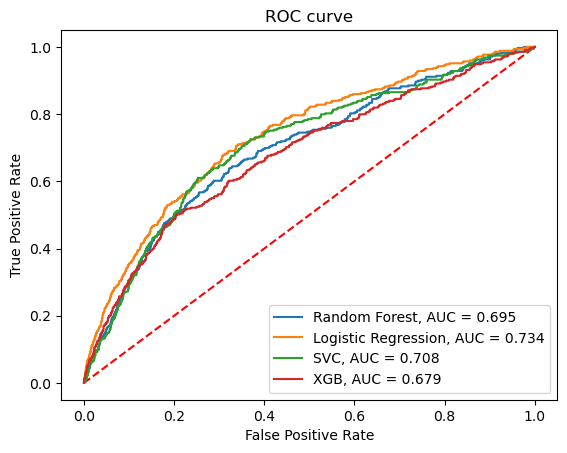

In [184]:
plt.plot([0, 1], [0, 1],'r--')

# Random forest
prob_rf = rf_model.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, prob_rf[:,1])
aucrf = roc_auc_score(y_test, prob_rf[:,1])
plt.plot(fpr, tpr, label=f'Random Forest, AUC = {str(round(aucrf,3))}')
# Logistic regression
prob_log = log_model1.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, prob_log[:,1])
auclog = roc_auc_score(y_test, prob_log[:,1])
plt.plot(fpr, tpr, label=f'Logistic Regression, AUC = {str(round(auclog,3))}')
# SVC
prob_svc = svc_model.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, prob_svc[:,1])
aucsvc = roc_auc_score(y_test, prob_svc[:,1])
plt.plot(fpr, tpr, label=f'SVC, AUC = {str(round(aucsvc,3))}')

prob_xgb = model_xgb.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, prob_xgb[:,1])
aucxgb = roc_auc_score(y_test, prob_xgb[:,1])
plt.plot(fpr, tpr, label=f'XGB, AUC = {str(round(aucxgb,3))}')

plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()

Logistic regression has the highest AUC value so we will select this model to perform our classification on the incoming purchase orders.